In [1]:
from model import Net2
from utils import calculate_mean_std_mnist,has_cuda,plot_single_mnist_img,which_device

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nns
import torch.nn.functional as F
torch.manual_seed(44) 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets

from torchsummary import summary
from tqdm import tqdm

In [3]:
has_cuda()

False

In [4]:
which_device()

device(type='cpu')

In [5]:
mnist_data = datasets.MNIST( root='../../data/', download=False, transform=transforms.ToTensor() ,)
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
mean,std = calculate_mean_std_mnist(mnist_data)

print(f'mnist data mean {mean}')
print(f"mnist data std  {std}")

mnist data mean 0.13065974414348602
mnist data std  0.3015038073062897


shape of batch =torch.Size([32, 1, 28, 28])
number of imgs in each batch= 32
shape of img = torch.Size([1, 28, 28])


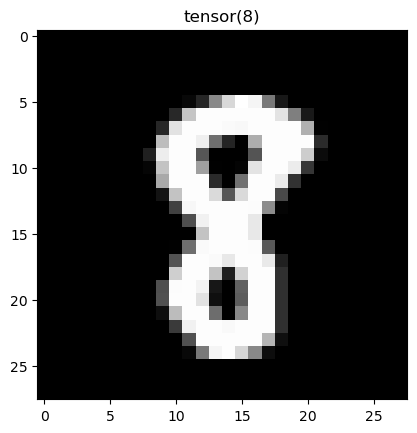

In [7]:
plot_single_mnist_img(mnist_data)

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean=(mean,), std=(std,) )
])


print(train_transforms)
print(test_transforms)

Compose(
    RandomApply(
    p=0.1
    CenterCrop(size=(22, 22))
)
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.13065974414348602,), std=(0.3015038073062897,))
)
Compose(
    ToTensor()
    Normalize(mean=(0.13065974414348602,), std=(0.3015038073062897,))
)


In [9]:
train_dataset = datasets.MNIST(root='../../data/',train=True,transform=train_transforms,download=False)
test_dataset  = datasets.MNIST(root='../../data/',train=False,transform=test_transforms,download=False)

In [10]:
device = 'cuda' if has_cuda() else 'cpu'
device

'cpu'

In [11]:
batch_size = 512
if device=='cpu':
  kwargs = {'batch_size': batch_size, 'shuffle': True}
else:
  kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}


test_loader = torch.utils.data.DataLoader(test_dataset, **kwargs)
train_loader = torch.utils.data.DataLoader(train_dataset, **kwargs)

print(kwargs)

{'batch_size': 512, 'shuffle': True}


In [12]:
model = Net2().to(device=device)
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

summary(model,input_data=(1,28,28));

conv1.0.weight		 torch.Size([16, 1, 3, 3])
conv1.1.weight		 torch.Size([16])
conv1.1.bias		 torch.Size([16])
conv1.3.weight		 torch.Size([32, 16, 3, 3])
conv1.4.weight		 torch.Size([32])
conv1.4.bias		 torch.Size([32])
trans1.0.weight		 torch.Size([16, 32, 1, 1])
trans1.1.weight		 torch.Size([16])
trans1.1.bias		 torch.Size([16])
conv2.0.weight		 torch.Size([16, 16, 3, 3])
conv2.1.weight		 torch.Size([16])
conv2.1.bias		 torch.Size([16])
conv2.3.weight		 torch.Size([64, 16, 3, 3])
conv2.4.weight		 torch.Size([64])
conv2.4.bias		 torch.Size([64])
trans2.0.weight		 torch.Size([16, 64, 1, 1])
trans2.2.weight		 torch.Size([16])
trans2.2.bias		 torch.Size([16])
conv3.0.weight		 torch.Size([10, 16, 3, 3])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 28, 28]          --
|    └─Conv2d: 2-1                       [-1, 16, 28, 28]          144
|    └─BatchNorm2d: 2-2                  [-1, 16, 28, 28]          32
|    

/home/muthu/ERAV1/session 6/Assignment/model.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}



def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
    
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

        train_acc.append(100*correct/processed)
        train_losses.append(train_loss/len(train_loader))

        
        
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2483 Batch_id=117 Accuracy=77.87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:15<00:00,  1.56it/s]


Test set: Average loss: 0.1758, Accuracy: 9486/10000 (94.86%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1233 Batch_id=117 Accuracy=95.90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:13<00:00,  1.60it/s]


Test set: Average loss: 0.1480, Accuracy: 9552/10000 (95.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1443 Batch_id=117 Accuracy=97.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:17<00:00,  1.52it/s]


Test set: Average loss: 0.0727, Accuracy: 9788/10000 (97.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0290 Batch_id=117 Accuracy=97.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:17<00:00,  1.52it/s]


Test set: Average loss: 0.0623, Accuracy: 9818/10000 (98.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0825 Batch_id=117 Accuracy=97.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:16<00:00,  1.54it/s]


Test set: Average loss: 0.0484, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0476 Batch_id=117 Accuracy=98.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:16<00:00,  1.54it/s]


Test set: Average loss: 0.0507, Accuracy: 9847/10000 (98.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0593 Batch_id=117 Accuracy=98.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:16<00:00,  1.54it/s]


Test set: Average loss: 0.0371, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0671 Batch_id=117 Accuracy=98.35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:17<00:00,  1.53it/s]


Test set: Average loss: 0.0530, Accuracy: 9830/10000 (98.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0302 Batch_id=117 Accuracy=98.43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:26<00:00,  1.36it/s]


Test set: Average loss: 0.0374, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0186 Batch_id=117 Accuracy=98.49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:26<00:00,  1.36it/s]


Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0714 Batch_id=117 Accuracy=98.59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:39<00:00,  1.19it/s]


Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0594 Batch_id=117 Accuracy=98.65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:26<00:00,  1.36it/s]


Test set: Average loss: 0.0401, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0286 Batch_id=117 Accuracy=98.71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:25<00:00,  1.37it/s]


Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0268 Batch_id=117 Accuracy=98.76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:27<00:00,  1.35it/s]


Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0618 Batch_id=117 Accuracy=98.78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:27<00:00,  1.34it/s]


Test set: Average loss: 0.0340, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.1356 Batch_id=117 Accuracy=98.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:34<00:00,  1.25it/s]


Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0508 Batch_id=117 Accuracy=99.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:26<00:00,  1.36it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0261 Batch_id=117 Accuracy=99.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:28<00:00,  1.34it/s]


Test set: Average loss: 0.0240, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0180 Batch_id=117 Accuracy=99.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:40<00:00,  1.17it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0101 Batch_id=117 Accuracy=99.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:29<00:00,  1.32it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.


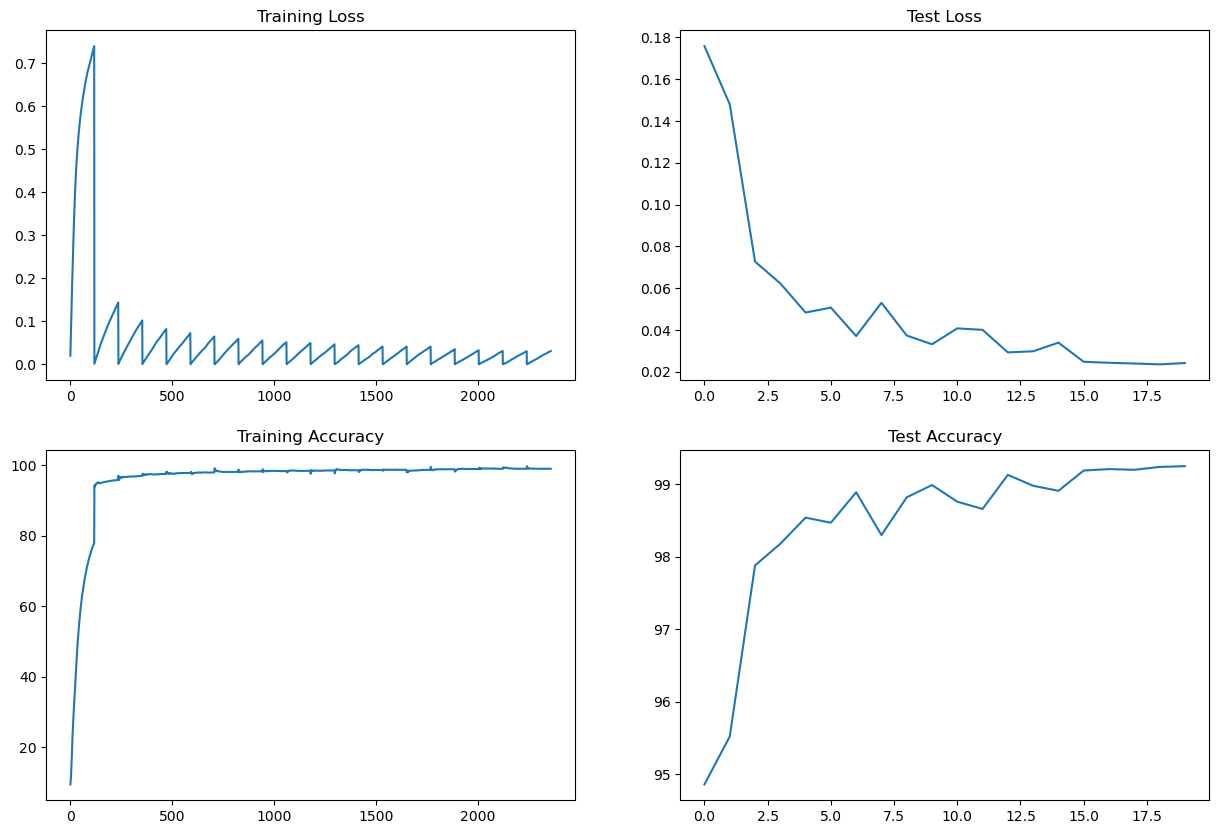

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()